# Pytorch 튜토리얼
### 이미지 분류기 학습하기

1. ``torchvision`` 을 사용하여 CIFAR10의 학습용 / 시험용 데이터셋을
   불러오고, 정규화(nomarlizing)합니다.
2. 합성곱 신경망(Convolution Neural Network)을 정의합니다.
3. 손실 함수를 정의합니다.
4. 학습용 데이터를 사용하여 신경망을 학습합니다.
5. 시험용 데이터를 사용하여 신경망을 검사합니다.
6. CIFAR10을 불러오고 정규화하기

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

### 1.데이터 셋 불러오고 정규화 하기

torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지입니다.
이를 [-1, 1]의 범위로 정규화된 Tensor로 변환합니다.

In [2]:
# 정규화 설정
transform = transforms.Compose( # 여러단계로 변환 시 묶어서 사용할 수 있게 함.
    [transforms.ToTensor(), # 데이터를 Tensor로 변환환
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # (mean, std, inplace=False) / 
                                                              # (R채널 평균, G ", B "), (R채널 표준편차, G ", B ") 
                                                              # 각 채널별 평균(mean)을 뺀 뒤 표준편차(std)로 나누어 정규화.

batch_size = 4

# 데이터세트 불러오기기
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)  # shuffle=True:데이터를 랜덤하게 뽑음

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


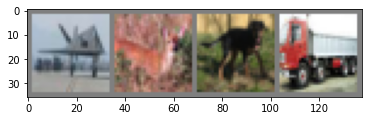

plane deer  dog   truck


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

2. 합성곱 신경망(Convolution Neural Network) 정의하기  
  
이전의 신경망 섹션에서 신경망을 복사한 후, (기존에 1채널 이미지만 처리하도록
정의된 것을) 3채널 이미지를 처리할 수 있도록 수정합니다.



In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

3. 손실 함수와 Optimizer 정의하기
  
교차 엔트로피 손실(Cross-Entropy loss)과 모멘텀(momentum) 값을 갖는 SGD를 사용합니다.

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. 신경망 학습하기
  
이제 재미있는 부분이 시작됩니다.
단순히 데이터를 반복해서 신경망에 입력으로 제공하고, 최적화(Optimize)만 하면
됩니다.



In [6]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.146
[1,  4000] loss: 1.775
[1,  6000] loss: 1.650
[1,  8000] loss: 1.550
[1, 10000] loss: 1.515
[1, 12000] loss: 1.466
[2,  2000] loss: 1.405
[2,  4000] loss: 1.385
[2,  6000] loss: 1.354
[2,  8000] loss: 1.325
[2, 10000] loss: 1.287
[2, 12000] loss: 1.285
Finished Training


학습한 모델을 저장해보겠습니다:

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

PyTorch 모델을 저장하는 자세한 방법은 `여기 <https://pytorch.org/docs/stable/notes/serialization.html>`_
를 참조해주세요.

5. 시험용 데이터로 신경망 검사하기
  

지금까지 학습용 데이터셋을 2회 반복하며 신경망을 학습시켰습니다.
신경망이 전혀 배운게 없을지도 모르니 확인해봅니다.

신경망이 예측한 출력과 진짜 정답(Ground-truth)을 비교하는 방식으로 확인합니다.
만약 예측이 맞다면 샘플을 '맞은 예측값(correct predictions)' 목록에 넣겠습니다.

첫번째로 시험용 데이터를 좀 보겠습니다.



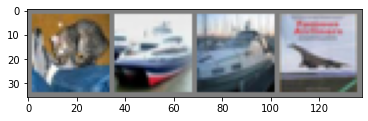

GroundTruth:  cat   ship  ship  plane


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

이제, 저장했던 모델을 불러오도록 하겠습니다 (주: 모델을 저장하고 다시 불러오는
작업은 여기에서는 불필요하지만, 어떻게 하는지 설명을 위해 해보겠습니다):



In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

좋습니다, 이제 이 예제들을 신경망이 어떻게 예측했는지를 보겠습니다:



In [10]:
outputs = net(images)

출력은 10개 분류 각각에 대한 값으로 나타납니다. 어떤 분류에 대해서 더 높은 값이
나타난다는 것은, 신경망이 그 이미지가 해당 분류에 더 가깝다고 생각한다는 것입니다.
따라서, 가장 높은 값을 갖는 인덱스(index)를 뽑아보겠습니다:



In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  frog  car   car   plane


결과가 괜찮아보이네요.

그럼 전체 데이터셋에 대해서는 어떻게 동작하는지 보겠습니다.



In [12]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


(10가지 분류 중에 하나를 무작위로) 찍었을 때의 정확도인 10% 보다는 나아보입니다.
신경망이 뭔가 배우긴 한 것 같네요.

그럼 어떤 것들을 더 잘 분류하고, 어떤 것들을 더 못했는지 알아보겠습니다:



In [13]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 56.3 %
Accuracy for class: car   is 82.9 %
Accuracy for class: bird  is 54.5 %
Accuracy for class: cat   is 22.7 %
Accuracy for class: deer  is 33.0 %
Accuracy for class: dog   is 45.7 %
Accuracy for class: frog  is 67.4 %
Accuracy for class: horse is 68.4 %
Accuracy for class: ship  is 53.5 %
Accuracy for class: truck is 56.4 %


GPU에서 학습하기
----------------
Tensor를 GPU로 이동했던 것처럼, 신경망 또한 GPU로 옮길 수 있습니다.

먼저 (CUDA를 사용할 수 있다면) 첫번째 CUDA 장치를 사용하도록 설정합니다:



In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다:

print(device)

cpu
